# Big Data EX3 - Spark MLib 
# Yosi Amiga 

In [1]:
!pip install pyspark

In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, BinaryLogisticRegressionSummary
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer,IndexToString
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
from pyspark.sql.functions import cast
import matplotlib.pyplot as plt

## DATASET CLEANING SECTION 

In [2]:
# Start a Spark session
spark = SparkSession.builder.appName("Random Forest Example").getOrCreate()

# Load the dataset
train_df = spark.read.text("adult.data")
test_df = spark.read.text("adult.test")


In [3]:
def dataframeCleaning(df):
    # Split the values in the first column based on the "," delimiter
    df = df.select(split(df.value, ", ").alias("features"))
    # Get the number of columns
    num_of_cols = len(df.select("features").first()[0])
    # Create the new columns' names
    col_names = ["col" + str(i) for i in range(num_of_cols)]
    # Create the new columns
    for i, col_name in enumerate(col_names):
        df = df.withColumn(col_name, df["features"][i])
    # drop the old column
    df = df.drop("features")
    # Rename the columns to the desired names
    df = df.withColumnRenamed("col0", "age") \
        .withColumnRenamed("col1", "workclass") \
        .withColumnRenamed("col2", "fnlwgt") \
        .withColumnRenamed("col3", "education") \
        .withColumnRenamed("col4", "education-num") \
        .withColumnRenamed("col5", "marital-status") \
        .withColumnRenamed("col6", "occupation") \
        .withColumnRenamed("col7", "relationship") \
        .withColumnRenamed("col8", "race") \
        .withColumnRenamed("col9", "sex") \
        .withColumnRenamed("col10", "capital-gain") \
        .withColumnRenamed("col11", "capital-loss") \
        .withColumnRenamed("col12", "hours-per-week") \
        .withColumnRenamed("col13", "native-country") \
        .withColumnRenamed("col14", "Yearly-income(Label)")

    # Set all the values of '?' to be None, it is a garbage value
    df = df.replace("?", None)

    # Each non numeric column value should be represented as a double value in the final dataset
    features = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex",
                "native-country"]
    for feature in features:
        # Create a StringIndexer object
        indexer = StringIndexer(inputCol=feature, outputCol=feature + "_index", handleInvalid='keep')
        # Fit the indexer on your dataset and transform the data
        indexer_model = indexer.fit(df)
        df = indexer_model.transform(df)
        df = df.drop(feature)
        df = df.withColumnRenamed(feature + "_index", feature)

    # convert the value column from string to double
    df = df.withColumn("age", col("age").cast('double'))
    df = df.withColumn("fnlwgt", col("fnlwgt").cast('double'))
    df = df.withColumn("education-num", col("education-num").cast('double'))
    df = df.withColumn("capital-gain", col("capital-gain").cast('double'))
    df = df.withColumn("capital-loss", col("capital-loss").cast('double'))
    df = df.withColumn("hours-per-week", col("hours-per-week").cast('double'))

    indexer = StringIndexer(inputCol="Yearly-income(Label)", outputCol="label")
    indexer_model = indexer.fit(df)
    df = indexer_model.transform(df)
    df = df.drop("Yearly-income(Label)")
    return df

In [4]:
# Clean and set up data for model creation
train_df = dataframeCleaning(train_df)
test_df = dataframeCleaning(test_df)


### Train Dataframe

In [5]:
train_df.show(30)

+----+--------+-------------+------------+------------+--------------+---------+---------+--------------+----------+------------+----+---+--------------+-----+
| age|  fnlwgt|education-num|capital-gain|capital-loss|hours-per-week|workclass|education|marital-status|occupation|relationship|race|sex|native-country|label|
+----+--------+-------------+------------+------------+--------------+---------+---------+--------------+----------+------------+----+---+--------------+-----+
|39.0| 77516.0|         13.0|      2174.0|         0.0|          40.0|      3.0|      2.0|           1.0|       3.0|         1.0| 0.0|0.0|           0.0|  0.0|
|50.0| 83311.0|         13.0|         0.0|         0.0|          13.0|      1.0|      2.0|           0.0|       2.0|         0.0| 0.0|0.0|           0.0|  0.0|
|38.0|215646.0|          9.0|         0.0|         0.0|          40.0|      0.0|      0.0|           2.0|       8.0|         1.0| 0.0|0.0|           0.0|  0.0|
|53.0|234721.0|          7.0|         0.

### Test Dataframe

In [6]:
test_df.show(30)

+----+--------+-------------+------------+------------+--------------+---------+---------+--------------+----------+------------+----+---+--------------+-----+
| age|  fnlwgt|education-num|capital-gain|capital-loss|hours-per-week|workclass|education|marital-status|occupation|relationship|race|sex|native-country|label|
+----+--------+-------------+------------+------------+--------------+---------+---------+--------------+----------+------------+----+---+--------------+-----+
|25.0|226802.0|          7.0|         0.0|         0.0|          40.0|      0.0|      5.0|           1.0|       6.0|         2.0| 1.0|0.0|           0.0|  0.0|
|38.0| 89814.0|          9.0|         0.0|         0.0|          50.0|      0.0|      0.0|           0.0|      10.0|         0.0| 0.0|0.0|           0.0|  0.0|
|28.0|336951.0|         12.0|         0.0|         0.0|          40.0|      2.0|      6.0|           0.0|      11.0|         0.0| 0.0|0.0|           0.0|  1.0|
|44.0|160323.0|         10.0|      7688.

### Features:

In [7]:
feature_names = train_df.columns
feature_names

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'label']

## Model Creation Section

### A. Use RandomForestClassifier to build a classification model on the training data.
### Tune the hyperparameters numTrees, subsamplingRate, and featureSubsetStrategy.

#### Create the model and hyperparameters

In [8]:
trainingData = train_df
testData = test_df
# Create a vector assembler to combine all feature columns into a single vector column
assembler = VectorAssembler(inputCols=trainingData.columns[:-1], outputCol="features")

## Create the Random Forest Classifier


In [9]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features",maxBins=100)

In [10]:
# Create a pipeline to combine the vector assembler and the classifier
pipeline = Pipeline(stages=[assembler, rf])

In [11]:
# Create a param grid builder to specify the range of values for the hyperparameters
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.subsamplingRate, [0.5, 0.7, 1.0]) \
    .addGrid(rf.featureSubsetStrategy, ["auto", "sqrt", "log2"]) \
    .build()

In [12]:
# Fit the model to the training data
# model = cv.fit(trainingData)

## Binary model:

In [13]:
# Binary classicivation 
binary_cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=3)

In [14]:
# Fit the model to the training data
model_binary = binary_cv.fit(trainingData)

## Evaluate the model performance

In [15]:
# Use the best model to predict on the test data
predictions = model_binary.transform(testData)

# Evaluate the model using the BinaryClassificationEvaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
accuracy = binary_evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8957586731293937


## Find the best value of the hyperparameters: 
## "numTrees", "subsamplingRate", "featureSubsetStrategy"

In [16]:
bestModel = model_binary.bestModel
best_param = bestModel.stages[1].extractParamMap()

# Iterate over the dictionary and extract the values of the best hyperparameters
best_params = {}
for k, v in best_param.items():
    if k.name in ["numTrees", "subsamplingRate", "featureSubsetStrategy"]:
        best_params[k.name] = v

# Print the extracted best hyperparameters
print("Best hyperparameters:")
for k, v in best_params.items():
    print("\t{}: {}".format(k, v))


Best hyperparameters:
	featureSubsetStrategy: auto
	numTrees: 100
	subsamplingRate: 0.5


## B. By checking feature Importances, which features are the most important? 
## Try to give an analysis on your results

In [17]:
# Access the feature importances
importances = bestModel.stages[-1].featureImportances
print("Feature Importance, " + str(importances))
# Extract the feature names
feature_names = trainingData.columns

Feature Importance, (14,[0,1,2,3,4,5,6,7,8,9,10,11,12,13],[0.033417661245507935,0.0009244077867689788,0.160615481611544,0.19864217120800276,0.026858763261694858,0.02277982383502459,0.0013834343251258891,0.014159911703902914,0.26170213432906664,0.0763511824232126,0.193295266135761,0.00012341388063875946,0.007432863915966488,0.002313484337782475])


In [18]:
# Create a list of (feature, importance) tuples
feature_importances = [(feature_names[i], importances[i]) for i in range(len(feature_names)-1)]

# Sort the feature importances by descending importance
feature_importances.sort(key=lambda x: x[1], reverse=True)

# Print the feature importances
for feature, importance in feature_importances:
    print("Feature:", feature, "Importance:", importance)

Feature: marital-status Importance: 0.26170213432906664
Feature: capital-gain Importance: 0.19864217120800276
Feature: relationship Importance: 0.193295266135761
Feature: education-num Importance: 0.160615481611544
Feature: occupation Importance: 0.0763511824232126
Feature: age Importance: 0.033417661245507935
Feature: capital-loss Importance: 0.026858763261694858
Feature: hours-per-week Importance: 0.02277982383502459
Feature: education Importance: 0.014159911703902914
Feature: sex Importance: 0.007432863915966488
Feature: native-country Importance: 0.002313484337782475
Feature: workclass Importance: 0.0013834343251258891
Feature: fnlwgt Importance: 0.0009244077867689788
Feature: race Importance: 0.00012341388063875946


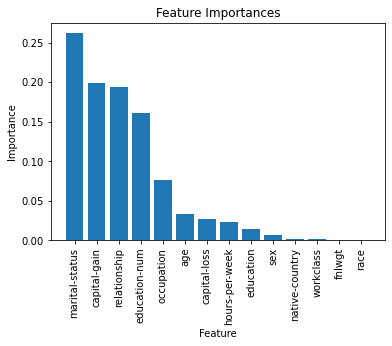

In [19]:
# Plot the feature importances
plt.bar(range(len(feature_importances)), [importance for _, importance in feature_importances], align='center')
plt.xticks(range(len(feature_importances)), [feature for feature, _ in feature_importances], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
# plt.figure(figsize=(10000, 60) ,dpi=1000000)
plt.show()

## CREATING GRADIENT-BOOST TREE CLASSIFIERS

In [20]:
# Create the Gradient Descent Classifier
gbt = GBTClassifier(labelCol="label", featuresCol="features",maxBins=100)
# Repeat the same process for GBTClassifier
pipeline_gbt = Pipeline(stages=[assembler, gbt])
# Repeat the same process for GBTClassifier
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [5, 10, 15]) \
    .addGrid(gbt.maxDepth, [2, 4, 6]) \
    .addGrid(gbt.featureSubsetStrategy, ["auto", "sqrt", "log2"]) \
    .build()

## Binary Class:


In [21]:
# Binary classicivation 
binary_cv_gbt = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=3)

In [22]:
# Fit the model to the training data
model_gbt_binary = binary_cv_gbt.fit(trainingData)

### Create predictions for each model

In [23]:
# predictions_rf = model.transform(testData)
# predictions_gbt = model_gbt.transform(testData)
# model_binary
predictions_rf = model_binary.transform(testData)
predictions_gbt = model_gbt_binary.transform(testData)

In [24]:
# Create the evaluator object
evaluator = MulticlassClassificationEvaluator()

# Create BinaryClassificationMetrics

binary_metrics = BinaryClassificationEvaluator()

### Set the metric for accuracy

In [25]:
evaluator.setMetricName("accuracy")
accuracy_rf = evaluator.evaluate(predictions_rf)
accuracy_gbt = evaluator.evaluate(predictions_gbt)

In [26]:
print("Accuracy of Random Forest Classifier: ", accuracy_rf)
print("Accuracy of GBT Classifier: ", accuracy_gbt)

Accuracy of Random Forest Classifier:  0.8511147963884282
Accuracy of GBT Classifier:  0.8511147963884282


### Set the metric for F1 score


In [27]:
evaluator.setMetricName("f1")
f1_rf = evaluator.evaluate(predictions_rf)
f1_gbt = evaluator.evaluate(predictions_gbt)

In [28]:
print("F1 score of Random Forest Classifier: ", f1_rf)
print("F1 score of GBT Classifier: ", f1_gbt)

F1 score of Random Forest Classifier:  0.8375114416244959
F1 score of GBT Classifier:  0.8375114416244959


### Set the metric for AUC

In [29]:
evaluator.setMetricName("weightedPrecision")
auc_rf = evaluator.evaluate(predictions_rf)
auc_gbt = evaluator.evaluate(predictions_gbt)

In [30]:
print("AUC of Random Forest Classifier: ", auc_rf)
print("AUC of GBT Classifier: ", auc_gbt)

AUC of Random Forest Classifier:  0.8457734296840705
AUC of GBT Classifier:  0.8457734296840705


### Additional: True Positive and False Positive rate

In [31]:
evaluator.setMetricName("weightedTruePositiveRate")
tp_rf = evaluator.evaluate(predictions_rf)
tp_gbt = evaluator.evaluate(predictions_gbt)
print("TP of Random Forest Classifier: ", tp_rf)
print("TP of GBT Classifier: ", tp_gbt)
evaluator.setMetricName("weightedFalsePositiveRate")
fp_rf = evaluator.evaluate(predictions_rf)
fp_gbt = evaluator.evaluate(predictions_gbt)
print("FP of Random Forest Classifier: ", fp_rf)
print("FP of GBT Classifier: ", fp_gbt)

TP of Random Forest Classifier:  0.8511147963884282
TP of GBT Classifier:  0.8511147963884282
FP of Random Forest Classifier:  0.39697166081982094
FP of GBT Classifier:  0.39697166081982094


## Draw the ROC curves of testing results

In [32]:
new_model = pipeline.fit(trainingData)

+---+--------------------+
|FPR|                 TPR|
+---+--------------------+
|0.0|                 0.0|
|0.0|7.652085193215151E-4|
|0.0|0.011988266802703736|
|0.0|0.013518683841346767|
|0.0|0.014028822854227777|
+---+--------------------+
only showing top 5 rows

areaUnderROC: 0.9027826746926892


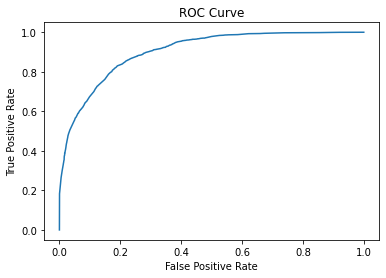

In [34]:
lrModel = new_model.stages[1]
trainingSummary = lrModel.summary

# Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# lr.setThreshold(bestThreshold)


import matplotlib.pyplot as plt
fpr = trainingSummary.roc.select('FPR').toPandas()
tpr = trainingSummary.roc.select('TPR').toPandas()

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()